In [1]:
import mcstasscript as ms
import make_QENS_instrument
import quizlib

In [2]:
quiz = quizlib.QENS_Quiz()

In [3]:
my_configurator = ms.Configurator()
#my_configurator.set_mcrun_path("/usr/bin/")
#my_configurator.set_mcstas_path("/usr/share/mcstas/3.4/")
my_configurator.set_line_length(120)
my_configurator.set_mcrun_path("/Applications/McStas-3.4.app/Contents/Resources/mcstas/3.4/bin")
my_configurator.set_mcstas_path("/Applications/McStas-3.4.app/Contents/Resources/mcstas/3.4")

# QENS exercise

This notebook contains code and questions for a McStas simulation of a simplified backscattering instrument that can investigate quasi-elastic scattering from samples.

Quasi-elastic scattering is inelastic scattering with small energy transfers and typically views a broadening of the elastic signal.
At ESS the backscattering instrument under construction is called MIRACLES and uses the indirect geometry time of flight technique,
here neutrons are scattered of the sample and some hit an analyzer afterwards.
This analyzer is angled such that the neutron is scattered almost backwards, and due to Braggs law this will happen with a given energy.

It turns out the precision of that energy is highest when the neutron is scattered back in the direction it came from,
but most instruments choose a slightly lower angle to avoid hitting the sample a second time.
The detector is then placed slightly above or below the sample.

Since the analyzer choose a specific energy, the final energy of the neutrons being recorded in the detector is known,
this can be used to propagate the time of the neutron to the sample position.
Then the time at that moment and the known pulse time can be used to calculate the time-of-flight,
which with the known distance gives the speed and thus energy before scattering in the sample.
The difference between the known initial and final energy provide the energy transfer, which for backscattering can be down to $\mu$eV, where most other inelastic techniques look at meV.

In this notebook you will get this simplified backscattering instrument and answer a few questions about the results. You will also get to improve it and run experiments with a small range of known and unknown samples.

### Get the instrument object
First we need the McStas instrument object. Here it is retrieved from a local python function that generates it.

In [4]:
instrument = make_QENS_instrument.make(input_path="run_folder")

The following components are found in the work_directory / input_path:
     Union_abs_logger_1D_space_event.comp
These definitions will be used instead of the installed versions.


## Investigate instrument
First investigate the instrument object `instrument` using some of the available methods.
All the methods that help do that start with the word show.
In particular, look at what parameters are available and take a look at the instrument geometry.

In [5]:
instrument.show_parameters()

double integration_time   = 21600      // [s] Time span of experiment
double energy_width_ueV   = 3          // [ueV] Simulated energy range
double n_pulses           = 3.0        // [1] Number of pulses from source
double sample_distance    = 8.0        // [m] Source Sample distance
string sample_choice      = "Elastic"  // Choice of sample type
double gamma_ueV          = 10         // [ueV] Energy width of known quasi-elastic sample
double analyzer_distance  = 3.0        // [m] Sample analyzer distance


In [6]:
instrument.show_instrument()

## Set parameters

Before running the instrument we need to set some parameters.
The most important one is the `sample_distance` parameter describing the distance between the source and the sample.
Given the need for high precision in determining the energy of the neutron, which of the following instrument lengths should be chosen?

- A: 30 m
- B: 60 m
- C: 150 m

In [7]:
quiz.question_1("C")

Correct!
Yes, a long instrument inherently provides a greater accuracy when determining
the neutron flight time and thus energy.


Set the `sample_distance` corresponding to the answer above and set the simulated energy width to 5 $\mu$eV.
Keep the sample type to `Elastic` and number of pulses to 1. Use the `set_parameters` method on the instrument object.

In [8]:
instrument.set_parameters(sample_distance=150, energy_width_ueV=5, sample_choice='"Elastic"', n_pulses=1)

In [9]:
# Validate the instrument by giving it to the question_2
quiz.question_2(instrument)

Correct!
The parameters of the instrument were correctly set!


## Instrument settings
Before running the simulation a few settings pertaining to the technical side should be set. These use a different method to clearly distinguish them from the instrument parameters. One important parameter is called `output_path` which sets the name of the generated folder.

In [10]:
instrument.settings(ncount=5e7, mpi=4, suppress_output=True, NeXus=True, output_path="first_run")

In [11]:
instrument.settings(mpi=2)

## Run the simulation

Now the simulation can be executed with the backengine method. Store the returned data in a python variable called `data`.

In [12]:
data = instrument.backengine()
data

[
 McStasData: signal_tof_all type: 2D  I:3.56137 E:0.0133438 N:369519.0,
 
 McStasData: signal_tof type: 2D  I:3.56137 E:0.0133438 N:369519.0,
 
 McStasDataEvent: signal_tof_event with 565125 events. Variables: p x y n id t,
 
 McStasData: signal_space type: 1D  I:3.56153 E:0.0133438 N:565127.0,
 
 McStasData: signal_time type: 1D  I:3.56137 E:0.0133438 N:369519.0]

Skipped plotting signal_tof_event as it contains event data.


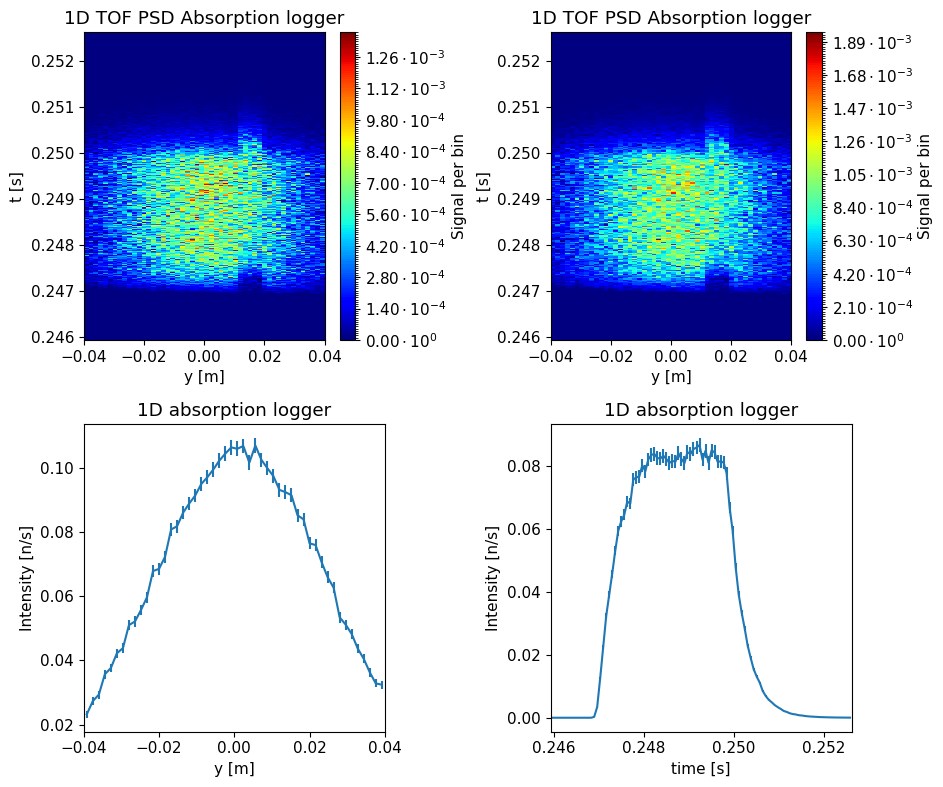

In [13]:
ms.make_sub_plot(data, figsize=(9.5, 8), log=False, orders_of_mag=3)

### Explanation of data

The data is all from a He3 tube which can only be reached from the sample by being scattered almost backwards from a Si analyzer crystal.
Two 1D monitors show the spatial and time distribution of the signal respectively.
The two 2D monitors show the correlation between time and position, though one will zoom out to capture multiple pulses if `n_pulse` is set to more than one.

### Questions

Look at the time distribution of the signal, which statement about this data is true?

- A: The data looks like a typical inelastic signal
- B: The data looks like the ESS pulse structure
- C: The data looks like a typical elastic signal
- D: The data looks like the analyzer selected to broad an energy range

In [14]:
quiz.question_3("B")

Correct!
Yes, the time distribution is dominated by the ESS pulse structure


Is this a problem for a backscattering instrument?
- A: Yes, the low time resolution means low energy resolution
- B: No, the low time resolution is not necessary for high energy resolution

In [15]:
quiz.question_4("A")

Correct!
Exactly, the time of flight is used to calculate the initial neutron energy


How can the instrument be improved? 
- A: Add a chopper to control the time aspect
- B: Add a slit before sample to reduce the illuminated area
- C: Add a slit before analyzer to ensure same angle
- D: Add a spin polarizer to select spin state

In [16]:
quiz.question_5("A")

Correct!
Yes, that would limit the uncertainty on the time of flight


## Improve the instrument

In order to improve the performance of the instrument, we will add a McStas component.
The first aspect to consider when doing so is where to place it, both in the component sequence and its physical location.
We start by looking at the code sequence.

### McStas sequence 

Use either the `show_diagram` or `show_components` method on the instrument object to get an overview of the component sequence in the instrument.
Where would you place the new component?

- A: After the source
- B: Before the sample position
- C: After the sample position
- D: After the analyzer

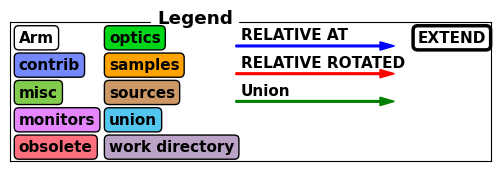

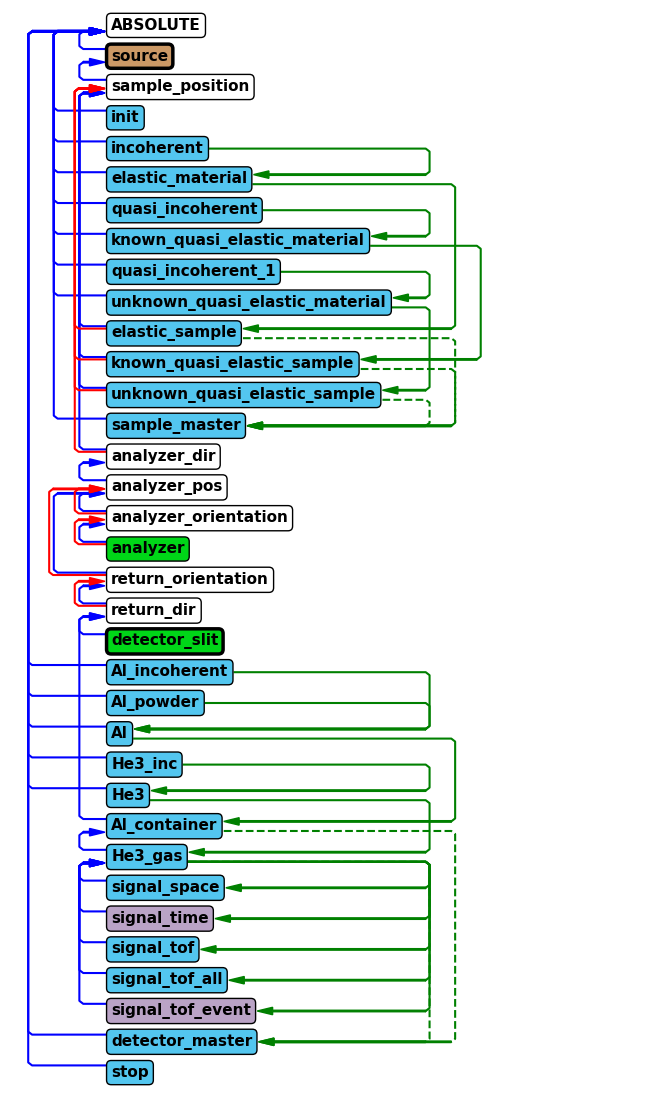

In [17]:
instrument.show_diagram()

In [18]:
quiz.question_6("B")

Correct!
Technically yes, but only because we are not simulating a guide between source
and sample.


### Which component

Now we need to select what type of component to add to the instrument, here we will need the `DiskChopper` component.
Use the `component_help` method on the instrument to learn more about this component.

In [19]:
instrument.component_help("DiskChopper")

 ___ Help DiskChopper __________________________________________________________________________________________________
|optional parameter|required parameter|default value|user specified value|
theta_0 = 0.0 [deg] // Angular width of the slits.
radius = 0.5 [m] // Radius of the disc
yheight [m] // Slit height (if = 0, equal to radius). Auto centering of beam at half height.
nu [Hz] // Frequency of the Chopper, omega=2*PI*nu (algebraic sign defines the direction of rotation)
nslit = 3.0 [1] // Number of slits, regularly arranged around the disk
jitter = 0.0 [s] // Jitter in the time phase
delay = 0.0 [s] // Time 'delay'
isfirst = 0.0 [0/1] // Set it to 1 for the first chopper position in a cw source (it then spreads the neutron time 
                       distribution) 
n_pulse = 1.0 [1] // Number of pulses (Only if isfirst)
abs_out = 1.0 [0/1] // Absorb neutrons hitting outside of chopper radius?
phase = 0.0 [deg] // Angular 'delay' (overrides delay)
xwidth = 0.0 [m] // Horizontal s

### Chopper calculations

When adding a chopper one need to perform some calculations on delay and frequency.
For this exercise, those calculations can be added to the instrument using a function in this folder

In [20]:
make_QENS_instrument.add_chopper_code(instrument)

To see what variables are used in the instrument, one can use the `show_variables` method like below.

In [21]:
instrument.show_variables()

DECLARE VARIABLES 
type    variable name              array length  value               
-------------------------------------------------------------------
double  detector_offset                          0.25                
double  analyzer_angle                                               
double  backscattering_wavelength                                    
double  backscattering_energy                                        
double  energy_width_meV                                             
double  min_energy                                                   
double  max_energy                                                   
double  min_wavelength                                               
double  max_wavelength                                               
double  t_min_sample                                                 
double  t_max_sample                                                 
double  t_max_sample_pulses                                          
dou

### Add chopper component and set parameters

Use the `add_component` method on the instrument to add a chopper.
Place it in the component sequence by using either the `before` or `after` keyword argument.

Set the parameters:

- `yheight`: 0.05 m
- `radius`: 0.7 m
- `nslit`: 1.0
- `nu`, `delay` and `theta_0`: To the variables calculated in the instrument (use quotation marks)

In [22]:
chopper = instrument.add_component("chopper", "DiskChopper", after="source")
chopper.set_parameters(
    yheight=0.05,
    radius=0.7,
    nu="chopper_frequency",
    nslit=1.0,
    delay="chopper_delay",
    theta_0="chopper_theta",
)

In [23]:
# Validate the instrument again
quiz.question_7(instrument)

Correct!
The DiskChopper was added at the right point in the component sequence!


### Placing the component in space

The next physical location of the component need to be specified, which is done using the `set_AT` component.
This method takes a list of 3 numbers, corresponding to the `x`, `y` and `z` coordinates of the component.

One can also specify in what coordinate system one wants to work, which can be that of any preceeding component.
Use the `RELATIVE` keyword to work in the `source` coordinate system.
The position of the chopper is needed for calculating phase, so it is available as a variable in the instrument, use this variable to set the position.

In [24]:
chopper.set_AT("chopper_distance", RELATIVE="source")

In [25]:
quiz.question_8(instrument)

Correct!
The DiskChopper was added at the right point in the component sequence!


### Verify new component

Now that the chopper has been added to the instrument, lets show the component sequence again to verify it was added correctly.

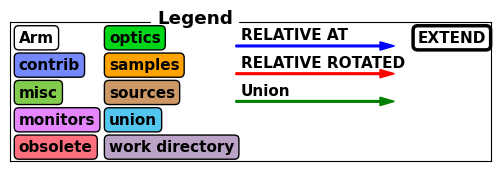

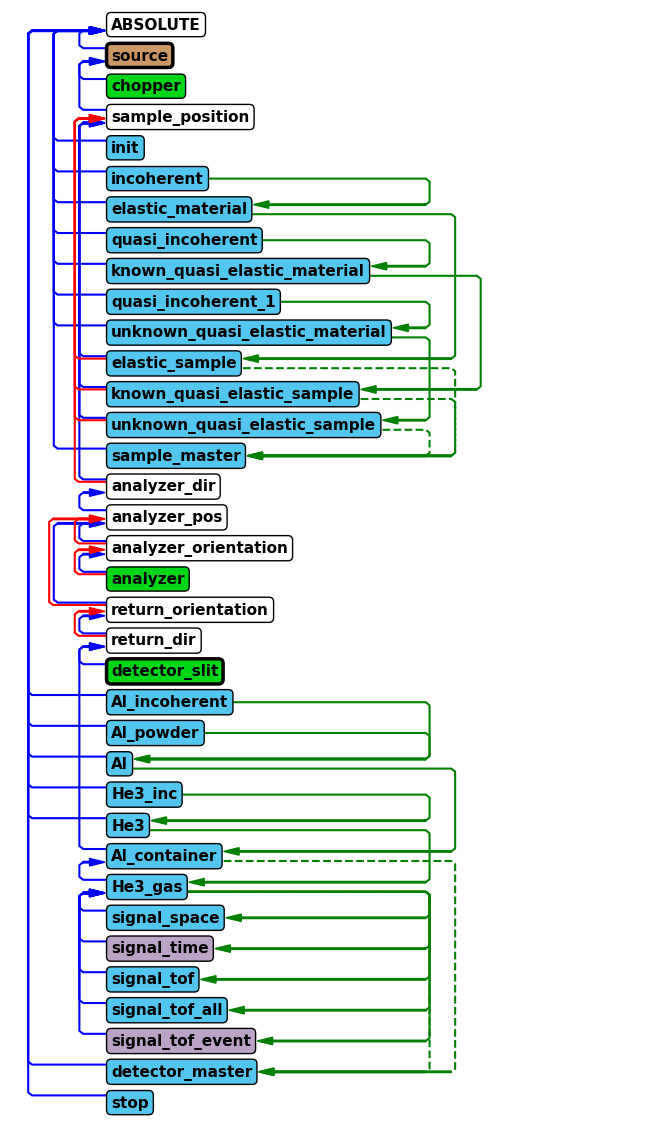

In [26]:
instrument.show_diagram()

## Run improved instrument

Run the improved instrument with the following parameters:

- `sample_distance`: 150 m
- `energy_width_ueV`: 5 ueV
- `sample_choice`: '"Elastic"'
- `frequency_multiplier`: 10 (This controls the ratio between chopper and source frequency)

Use the `settings` method to set a reasonable name, including the sample type and number of pulses currently used.

Store the resulting data in a variable called `data_improved`.

In [27]:
instrument.settings(output_path="QENS_elastic_1_pulse")
instrument.set_parameters(energy_width_ueV=5, sample_choice='"Elastic"', n_pulses=1, frequency_multiplier=10)

data_improved = instrument.backengine()

We will be reading values of the produced graphs, in those cases the %matplotlib widget mode helps as it provides information on the cursor position over the graphs.

In [28]:
# %matplotlib widget

Skipped plotting signal_tof_event as it contains event data.


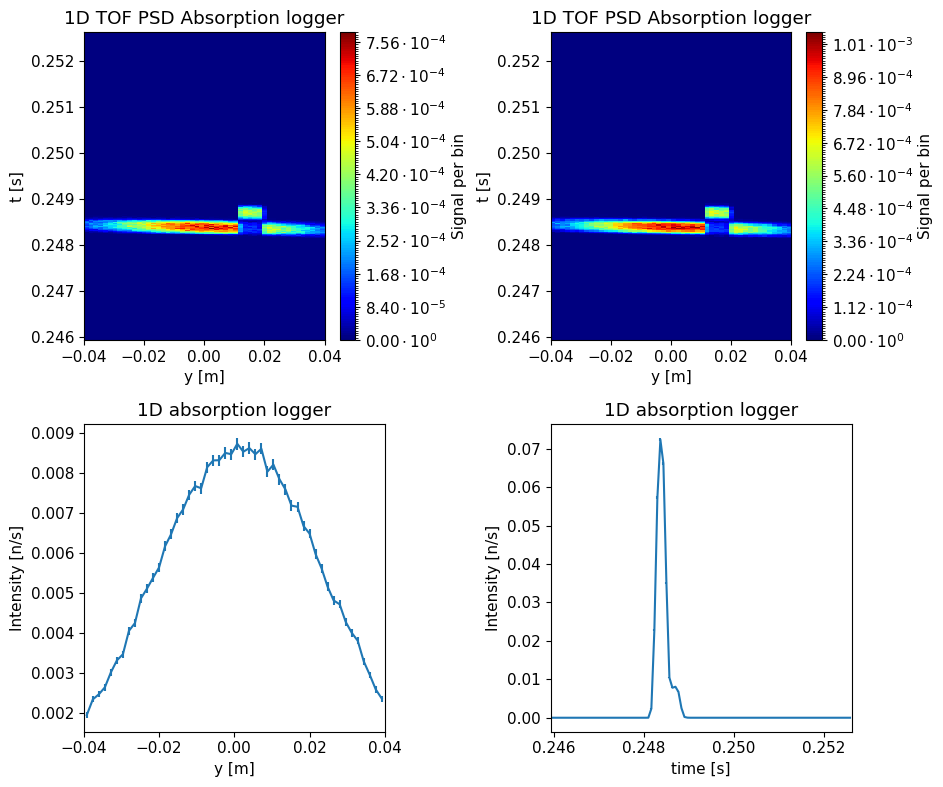

In [29]:
ms.make_sub_plot(data_improved, figsize=(9.5, 8), log=False, orders_of_mag=4)

### Time resolution

- Q: What is the time resolution of the instrument? (at multiplier=10, FWHM)
- A: 0.246 ms

In [30]:
quiz.question_9(0.246E-3)

Correct!
Yes!


### Run with known calibration sample

We know run with a known calibration sample, its energy width can be adjusted with the gamma_ueV (HWHM).
Run with the following parameters:

- `sample_choice`: '"Known_quasi-elastic"'
- `gamma_ueV`: 12 ueV
- `energy_width_ueV`: 150 ueV

Again set a descriptive name, call the produced data `data_known`.

In [31]:
instrument.settings(output_path="QENS_known_quasi_elastic_1_pulse")
instrument.set_parameters(energy_width_ueV=150, sample_choice='"Known_quasi-elastic"',
                          gamma_ueV=12, frequency_multiplier=10)

data_known = instrument.backengine()

Skipped plotting signal_tof_event as it contains event data.


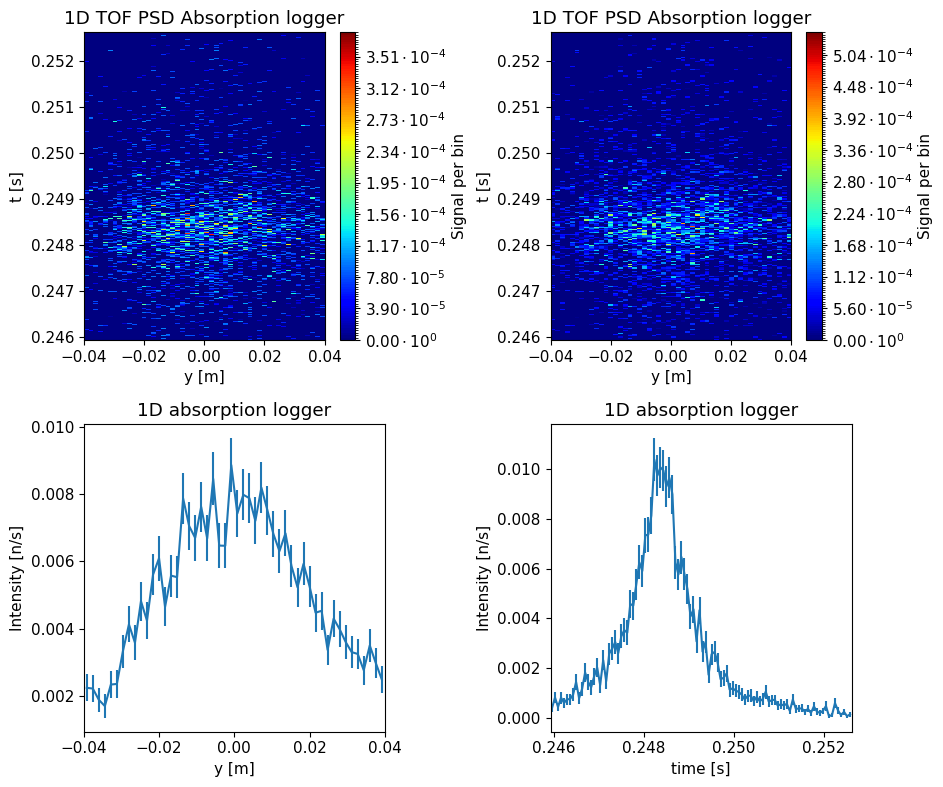

In [32]:
ms.make_sub_plot(data_known, figsize=(9.5, 8), log=False, orders_of_mag=4)

What is the time width when using a known sample with 12 ueV broadening? Insert the answer with units of seconds.

In [33]:
quiz.question_10(0.001)

Correct!
Yes!


### Run with unknown sample

- `sample_choice`: `"Unknown_quasi-elastic"`
- `energy_width_ueV`: 150 ueV

Again set a descriptive name, call the produced data `data_unknown`.

In [34]:
instrument.settings(
    output_path="QENS_unknown_quasi_elastic_1_pulse",
)

instrument.set_parameters(
    energy_width_ueV=150,
    sample_choice='"Unknown_quasi-elastic"',
    n_pulses=1,
    frequency_multiplier=10,
)

data_unknown = instrument.backengine()

Skipped plotting signal_tof_event as it contains event data.


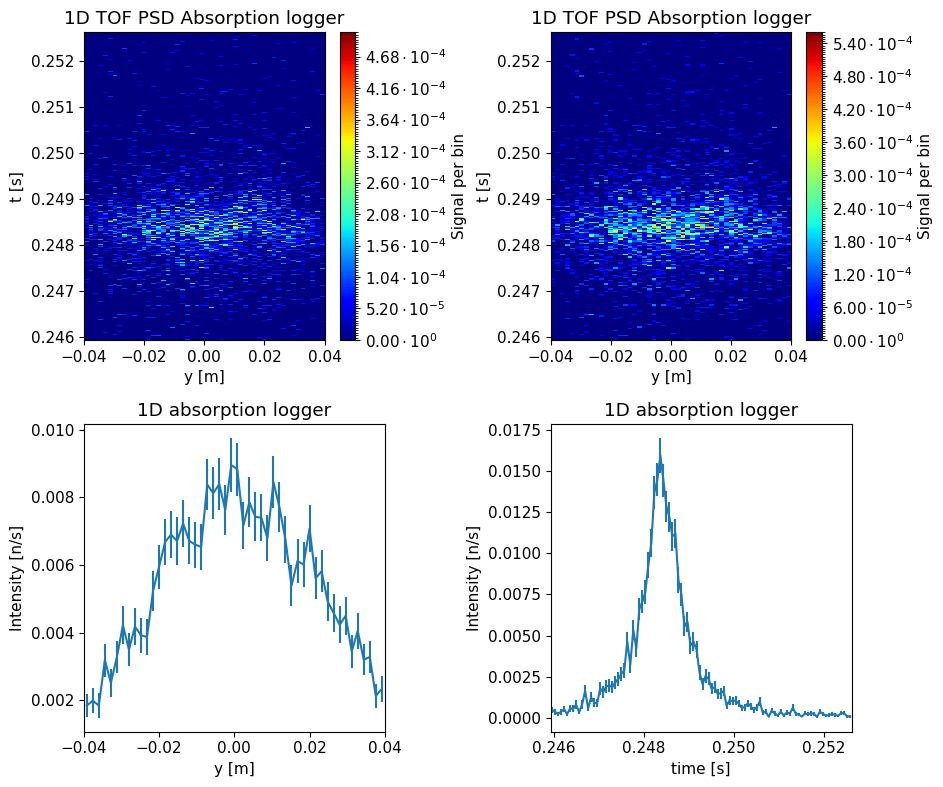

In [35]:
ms.make_sub_plot(data_unknown, figsize=(9.5, 8), log=False, orders_of_mag=4)

## Increase the number of pulses

Your final task is to re-run the simulations for the 3 different samples, using 3 pulses instead of 1. We will use this data in the exercises for the rest of the week.

**Hints:**

- Change the destination folder so that you don't overwrite the results from the 1-pulse simulations.
- Remember to adjust the `ncount` accordingly, we would like 3 times more rays now that we use 3 pulses.

**Solution:**

In [36]:
# Elastic sample
instrument.settings(
    ncount=1.5e8,
    output_path="QENS_elastic_3_pulse",
)
instrument.set_parameters(
    energy_width_ueV=5,
    sample_choice='"Elastic"',
    n_pulses=3,
    frequency_multiplier=10,
)
instrument.backengine()


# Known calibration sample
instrument.settings(
    ncount=1.5e8,
    output_path="QENS_known_quasi_elastic_3_pulse",
)
instrument.set_parameters(
    energy_width_ueV=150,
    sample_choice='"Known_quasi-elastic"',
    gamma_ueV=12,
    n_pulses=3,
    frequency_multiplier=10,
)
instrument.backengine()


# Unknown sample
instrument.settings(
    ncount=1.5e8,
    output_path="QENS_unknown_quasi_elastic_3_pulse",
)
instrument.set_parameters(
    energy_width_ueV=150,
    sample_choice='"Unknown_quasi-elastic"',
    n_pulses=3,
    frequency_multiplier=10,
)
instrument.backengine()

[
 McStasData: signal_tof_all type: 2D  I:0.822102 E:0.00758526 N:33864.0,
 
 McStasData: signal_tof type: 2D  I:0.272383 E:0.0043702 N:11082.0,
 
 McStasDataEvent: signal_tof_event with 34164 events. Variables: p x y n id t,
 
 McStasData: signal_space type: 1D  I:0.827002 E:0.0076085 N:34166.0,
 
 McStasData: signal_time type: 1D  I:0.272383 E:0.0043702 N:11082.0]